<a href="https://colab.research.google.com/github/Acabre21/machineLearning/blob/master/Problem3a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tuning Xception

I have replaced the VGG16 CNN with the Xeption CNN. I have also modified the classifier by adding another dense layer with 256 neurons and a softmax activation function. This CNN now uses three dense layers. In addition to that, I have also unfrozen the conv2d_6 layer. 

Validation loss: 0.5727039575576782

Validation accuracy: 0.972000002861023

## Feature extraction

Feature extraction consists of using the representations learned by a previous network to extract interesting features from new samples. These features are then run through a new classifier, which is trained from scratch.

We will use here the convolutional base of the Xception model to extract the features. We will feed these features to a densely connected classifier with dropout. We will fine-tune some layers.

In [3]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2020-04-21 22:43:54--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.194.128, 2404:6800:4003:c03::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.194.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  57.8MB/s    in 1.1s    

2020-04-21 22:43:55 (57.8 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

Note that the data provided by Google does not have a test set.

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

## Build network with Xception convolution base and custom densely connected layers

### Load the convolutional base

In [0]:
from keras.applications import Xception

conv_base = Xception(
    weights='imagenet', 
    include_top=False, 
    input_shape=(150, 150, 3))

### Freeze the convolutional base

In [0]:
conv_base.trainable = False

### Concatenate the convolutional base and densely connected layers

In [0]:
from keras import layers
from keras import models
from keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
# new Dense layer
model.add(layers.Dense(256, activation='softmax'))
model.add(layers.Dense(1, activation='sigmoid'))

In [12]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 5, 5, 2048)        20861480  
_________________________________________________________________
flatten_1 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               13107456  
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 34,034,985
Trainable params: 13,173,505
Non-trainable params: 20,861,480
_________________________________________________________________


## Train the model end to end with frozen convolutional base

In [13]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

# data augmentation

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

# compile model

model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.RMSprop(lr=2e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 24s 239ms/step - loss: 0.6611 - acc: 0.7860 - val_loss: 0.6395 - val_acc: 0.9290
Epoch 2/30
100/100 [==============================] - 20s 203ms/step - loss: 0.6526 - acc: 0.8340 - val_loss: 0.6254 - val_acc: 0.9630
Epoch 3/30
100/100 [==============================] - 21s 206ms/step - loss: 0.6488 - acc: 0.8445 - val_loss: 0.6309 - val_acc: 0.9650
Epoch 4/30
100/100 [==============================] - 21s 208ms/step - loss: 0.6489 - acc: 0.8385 - val_loss: 0.6290 - val_acc: 0.9660
Epoch 5/30
100/100 [==============================] - 20s 203ms/step - loss: 0.6455 - acc: 0.8560 - val_loss: 0.6299 - val_acc: 0.9630
Epoch 6/30
100/100 [==============================] - 20s 199ms/step - loss: 0.6450 - acc: 0.8600 - val_loss: 0.6283 - val_acc: 0.9690
Epoch 7/30
100/100 [==============================] - 20s 200ms/step - loss: 0.6436 - acc: 0.8670 - val_lo

## Display curves of loss and accuracy during training

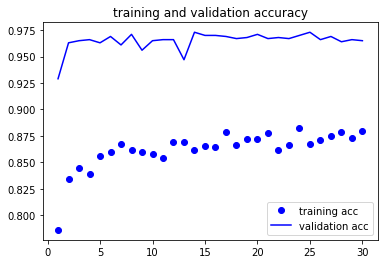

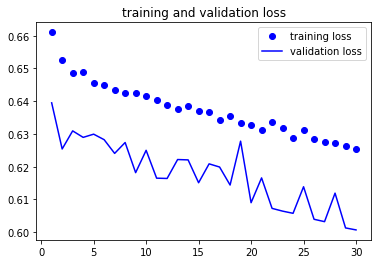

In [14]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

## Fine-tuning

In [21]:
conv_base.trainable = True

set_trainable = False

# unfreezing a different layer
for layer in conv_base.layers:
  # if layer.name == 'block5_conv1':
  if layer.name == 'conv2d_6':
    set_trainable = True
    # print('did it')
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False


did it


In [22]:
# compile model

model.compile(
    loss='binary_crossentropy',
    #
    # choose a smaller learning rate
    #
    optimizer=optimizers.RMSprop(lr=1e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/100
100/100 [==============================] - 39s 386ms/step - loss: 0.6249 - acc: 0.8790 - val_loss: 0.6110 - val_acc: 0.9370
Epoch 2/100
100/100 [==============================] - 29s 285ms/step - loss: 0.6220 - acc: 0.8925 - val_loss: 0.6277 - val_acc: 0.9420
Epoch 3/100
100/100 [==============================] - 29s 285ms/step - loss: 0.6198 - acc: 0.8995 - val_loss: 0.6244 - val_acc: 0.9360
Epoch 4/100
100/100 [==============================] - 28s 285ms/step - loss: 0.6204 - acc: 0.8910 - val_loss: 0.6131 - val_acc: 0.9270
Epoch 5/100
100/100 [==============================] - 28s 284ms/step - loss: 0.6162 - acc: 0.9145 - val_loss: 0.6019 - val_acc: 0.9380
Epoch 6/100
100/100 [==============================] - 28s 284ms/step - loss: 0.6149 - acc: 0.9165 - val_loss: 0.5982 - val_acc: 0.9360
Epoch 7/100
100/100 [==============================] - 28s 284ms/step - loss: 0.6145 - acc: 0.9180 - val_loss: 0.5996 - val_acc: 0.9480
Epoch 8/100
100/100 [===========================

## Display learning curves during fine-tuning

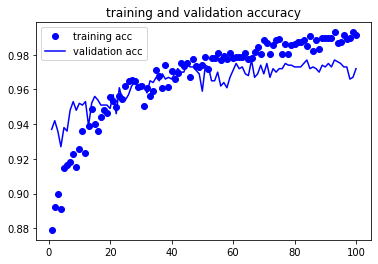

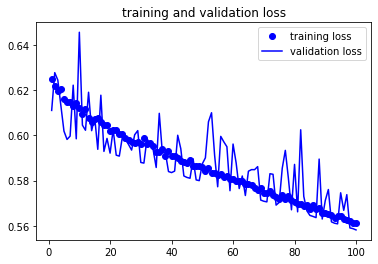

In [24]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

## Print out validation loss and accuracy

In [0]:
val_loss, val_acc = model.evaluate_generator(validation_generator, steps=50)

In [26]:
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

Validation loss: 0.5727039575576782
Validation accuracy: 0.972000002861023
